# Detect the ones who are only screened 

> run eligibility notebook

> run survey data notebook



In [42]:
%run "../eligibility.ipynb"
%run "../survey_data/survey_data.ipynb"

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [44]:
survey_data.shape
eligibility.shape

(51870, 19)

(39062, 31)

In [45]:
survey_data.columns
eligibility.columns

Index(['case_id', 'organisation', 'first_name', 'last_name', 'dob',
       'interview_date', 'adress', 'commune', 'commune_section',
       'interviewer_firstname', 'interviewer_lastname', 'is_your_parent_alive',
       'mothers_name', 'fathers_name', 'who_is_your_law_parent', 'total',
       'is_eligible_for_dep_hiv', 'age', 'already_in_a_group'],
      dtype='object')

Index(['case_id', 'dreams_code', 'organisation', 'id', 'phone',
       'not_selectable', 'first_name', 'last_name', 'dob', 'interview_date',
       'adress', 'commune', 'commune_section', 'interviewer_firstname',
       'interviewer_lastname', 'is_your_parent_alive', 'mothers_name',
       'fathers_name', 'total', 'who_is_your_law_parent', 'group_name',
       'id_group', 'hub_name', 'id_hub', 'eske_ou_lekol_deja',
       'depi_kile_ou_pa_al_lekol_with_label',
       'c61_depi_ki_l_ou_pa_al_lekl_ank', 'c6_ske_ou_te_oblije_double_deja',
       'kiyes_ki_peye_lekol_pou_ou', 'age', 'kpi_score'],
      dtype='object')

In [46]:
#survey_data[survey_data.organisation=="CARIS"]

## Eligibility

In [47]:
eligibility.dreams_code.fillna("null",inplace=True)

In [48]:
def tranche_age_classique(age):
        if age>=10 and age<=14:
            return "10-14"
        elif age>=15 and age<=19:
            return "15-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"
        
def tranche_age_mineur_majeur(age):
        if age>=10 and age<=17:
            return "10-17"
        elif age>=18 and age<=19:
            return "18-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"

In [49]:
eligibility['age_range'] = eligibility.age.map(tranche_age_classique)
eligibility['newage_range'] = eligibility.age.map(tranche_age_mineur_majeur)

In [50]:
import pandas as pd
from datetime import datetime

In [51]:
eligibility["date_entevyou"] = pd.to_datetime( eligibility.interview_date)

In [52]:
def fiscalYear21(date):
    if date.year == 2021 and date.month>=1 and date.month<=3:
        return "FY21Q2"
    elif date.year == 2020 and date.month>=10 and date.month<=12:
        return "FY21Q1"
    elif date.year == 2021 and date.month>=4 and date.month<=6:
        return "FY21Q3"
    elif date.year == 2021 and date.month>=7 and date.month<=9:
        return "FY21Q4"
    else:
        return "Q3fy21-Q4fy21"
    

    

def validTimeOnSystem(date):
    if date>= datetime.strptime("2020-04-01","%Y-%m-%d") and date<= datetime.now():
        return "required_Time_on"
    else:
        return "not_valid_time_on"


In [53]:
eligibility["fiscal_year"] = eligibility.date_entevyou.map(fiscalYear21)
eligibility["timeOn_system"] = eligibility.date_entevyou.map(validTimeOnSystem)

In [54]:
almost_eligibility = eligibility[(eligibility.dreams_code == "null")&
                                 (eligibility.timeOn_system=="required_Time_on")&
                                 (eligibility.age_range!="25-29")&
                                 (eligibility.age_range!="not_valid_age")]

In [55]:
almost_eligibility.dreams_code.count()

4731

In [56]:
def firstlastdob(df):
    return f"{df.first_name} {df.last_name} {df.dob}"

In [57]:
%%capture
almost_eligibility["unduplicate_me"] = almost_eligibility.apply(lambda df: firstlastdob(df),axis=1)
clean_eligibility =  almost_eligibility.drop_duplicates(subset=["unduplicate_me"])


In [58]:
clean_eligibility.dreams_code.count()

4709

## Survey data

In [59]:
survey_data["remove_duplicate"] = survey_data.apply(lambda df: firstlastdob(df),axis=1)

In [60]:
survey_data["date_entevyou"] = pd.to_datetime( survey_data.interview_date)
survey_data["fiscal_year"] = survey_data.date_entevyou.map(fiscalYear21)
survey_data["timeOn_system"] = survey_data.date_entevyou.map(validTimeOnSystem)
survey_data['age_range'] = survey_data.age.map(tranche_age_classique)
survey_data['newage_range'] = survey_data.age.map(tranche_age_mineur_majeur)

In [61]:
almost_survey_data = survey_data[(survey_data.already_in_a_group == "no")&
                                 (survey_data.timeOn_system=="required_Time_on")&
                                 (survey_data.age_range!="25-29")&
                                 (survey_data.age_range!="not_valid_age")&
                                 (survey_data.total>=14)]

In [62]:
almost_survey_data.case_id.count()

4730

In [63]:
clean_survey_data =  almost_survey_data.drop_duplicates(subset=["remove_duplicate"])

In [64]:
clean_survey_data.case_id.count()

4708

## what we want

In [65]:
id_form_survey_data = clean_survey_data[["case_id","already_in_a_group"]]

In [66]:
update_screening_data = id_form_survey_data.merge(clean_eligibility, on="case_id",how='right')

In [67]:
update_screening_data.case_id.count()

4709

In [68]:
update_screening_data.to_excel("update_screened.xlsx",index=False,na_rep="NULL")

In [69]:
update_screening_data.date_entevyou.min().strftime("%Y-%m-%d")
update_screening_data.date_entevyou.max().strftime("%Y-%m-%d")

'2020-05-25'

'2021-07-19'

## verification des 4360 Mastersheets

In [70]:
old_data = pd.read_excel("old_screened_4360.xlsx")

In [71]:
how_much_isin_old_data = update_screening_data[update_screening_data.case_id.isin(old_data.case_id)]

In [72]:
how_much_isnotin_old_data  = update_screening_data[~update_screening_data.case_id.isin(old_data.case_id)]

## count and date

In [73]:
old_data.case_id.count()
old_data.date_entevyou.min().strftime("%Y-%m-%d")
old_data.date_entevyou.max().strftime("%Y-%m-%d")

4360

'2020-04-18'

'2021-06-13'

In [74]:
how_much_isin_old_data.case_id.count()
how_much_isin_old_data.date_entevyou.min().strftime("%Y-%m-%d")
how_much_isin_old_data.date_entevyou.max().strftime("%Y-%m-%d")

3248

'2020-05-25'

'2021-06-13'

In [75]:
how_much_isnotin_old_data.case_id.count()
how_much_isnotin_old_data.date_entevyou.min().strftime("%Y-%m-%d")
how_much_isnotin_old_data.date_entevyou.max().strftime("%Y-%m-%d")

1461

'2020-06-14'

'2021-07-19'

## Verification with the newest from the list of JULY

In [86]:
onejuly = pd.read_excel("old_new_enroled_July.xlsx")
onejuly.case_id.count()
onejuly.date_entevyou.min().strftime("%Y-%m-%d")
onejuly.date_entevyou.max().strftime("%Y-%m-%d")

1328

'2020-06-14'

'2021-07-09'

In [88]:
how_much_isin_onejuly = how_much_isnotin_old_data[how_much_isnotin_old_data.case_id.isin(onejuly.case_id)]
how_much_isin_onejuly.case_id.count()
how_much_isin_onejuly.date_entevyou.min().strftime("%Y-%m-%d")
how_much_isin_onejuly.date_entevyou.max().strftime("%Y-%m-%d")

1303

'2020-06-14'

'2021-07-09'

In [89]:
how_much_isnotin_onejuly = how_much_isnotin_old_data[~how_much_isnotin_old_data.case_id.isin(onejuly.case_id)]
how_much_isnotin_onejuly.case_id.count()
how_much_isnotin_onejuly.date_entevyou.min().strftime("%Y-%m-%d")
how_much_isnotin_onejuly.date_entevyou.max().strftime("%Y-%m-%d")

158

'2020-08-26'

'2021-07-19'

## SAVE and PICTURE

In [76]:
how_much_isin_old_data.to_excel("Evolution_de_la_liste_restant_aServir.xlsx",na_rep="NULL", index=False)

In [77]:
how_much_isnotin_old_data.to_excel("Les_nouvelles_enroles_a_date.xlsx",na_rep="NULL",index=False)

In [ ]:
how_much_isin_onejuly.to_excel("evolution_des_1328.xlsx",na_rep="NULL",index=False)

In [ ]:
how_much_isnotin_onejuly.to_excel("new_screened_after_1328.xlsx",na_rep="NULL",index=False)

In [90]:
df = pd.DataFrame({"stage":["Liste_des_4360","Evolution_liste_4360","new_enroles_4360","Liste_des_1328","Evolution_liste_1328","new_enroles_1328"],
                   "data":[
                        old_data.case_id.count(),
                        how_much_isin_old_data.case_id.count(),
                        how_much_isnotin_old_data.case_id.count(),
                        onejuly.case_id.count(),
                        how_much_isin_onejuly.case_id.count(),
                        how_much_isnotin_onejuly.case_id.count()
                    ]}
)

df

,stage,data
0,Liste_des_4360,4360
1,Evolution_liste_4360,3248
2,new_enroles_4360,1461
3,Liste_des_1328,1328
4,Evolution_liste_1328,1303
5,new_enroles_1328,158


In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, "La situation des formulaires d'enrolement sur le systeme")

Text(0.0, 2180.0, '4360')

Text(1.0, 1624.0, '3248')

Text(2.0, 730.5, '1461')

Text(3.0, 664.0, '1328')

Text(4.0, 651.5, '1303')

Text(5.0, 79.0, '158')

Text(-80, -20, 'source: HIVHaiti')

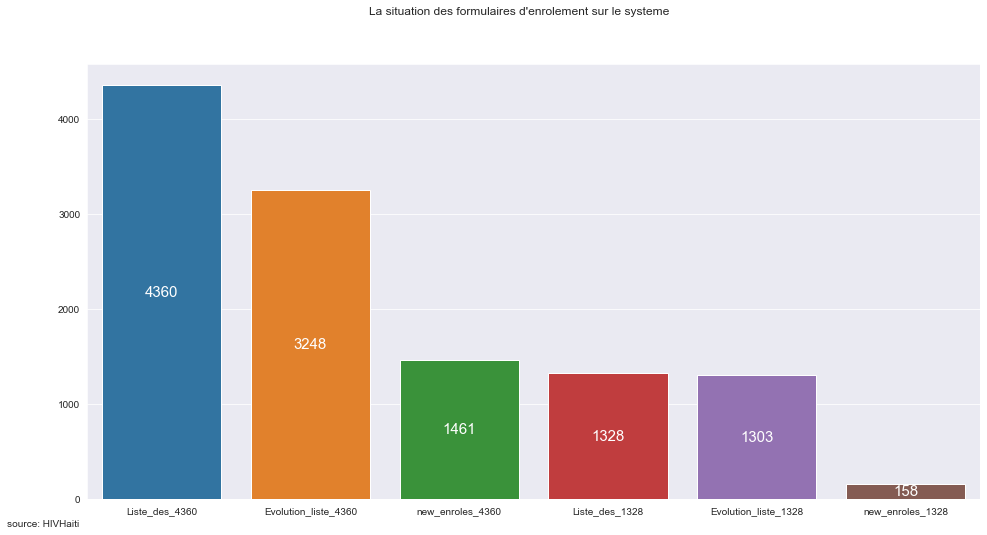

In [91]:
plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
splot = sns.barplot(x="stage",y="data",data=df)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("La situation des formulaires d'enrolement sur le systeme")
for p in splot.patches:
    height = p.get_height()
    plt.text(
                    p.get_x() + p.get_width()/2, 
                    0.5*p.get_height() + p.get_y(),
                    '{:1.0f}'.format(height), 
                    ha='center', va='center',
                    size=15,
                    fontdict=dict(color="white",fontsize=15)
                )
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)
plt.savefig("Evolution_screening",dpi=400)